In [2]:
import pandas as pd
import requests
import gzip
from sklearn.linear_model import LogisticRegression
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

Download the umitab.txt from GEO

In [3]:
# Download umitab file
url = "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE54006&format=file&file=GSE54006%5Fumitab%2Etxt%2Egz"
response = requests.get(url)
with open("GSE54006_umitab.txt.gz", "wb") as file:
    file.write(response.content)

# Unzip the file
with gzip.open("GSE54006_umitab.txt.gz", "rb") as f_in:
    with open("GSE54006_umitab.txt", "wb") as f_out:
        f_out.write(f_in.read())


Load the experimental design txt

In [4]:
# load the experimental design, skipping the two comment lines
meta = pd.read_csv(
    "GSE54006_experimental_design.txt",
    sep="\t",
    skiprows=5,
    header=1,
)

meta.head(10)

,index,sequencing_batch,amplification_batch,mouse_ID,pool_barcode,sample_barcode,plate_id,well_id,number_of_cells,sorting_markers,RMT_length,group_name,ERCC_dilution,ERCC_volume_ul,Column_name_in_processed_data_file
0,1,1,0,NaN,NNNNNN,CTACCA,1.0,A1,1,CD11c+,4,CD11c+,0.00002,0.01,0_1
1,2,1,0,NaN,NNNNNN,CATGCT,1.0,B1,1,CD11c+,4,CD11c+,0.00002,0.01,0_2
2,3,1,0,NaN,NNNNNN,GCACAT,1.0,C1,1,CD11c+,4,CD11c+,0.00002,0.01,0_3
3,4,1,0,NaN,NNNNNN,TGCTCG,1.0,D1,1,CD11c+,4,CD11c+,0.00002,0.01,0_4
4,5,1,0,NaN,NNNNNN,AGCAAT,1.0,E1,1,CD11c+,4,CD11c+,0.00002,0.01,0_5
5,6,1,0,NaN,NNNNNN,AGTTGC,1.0,F1,1,CD11c+,4,CD11c+,0.00002,0.01,0_6
6,7,1,0,NaN,NNNNNN,CCAGTT,1.0,G1,1,CD11c+,4,CD11c+,0.00002,0.01,0_7
7,8,1,0,NaN,NNNNNN,TTGAGC,1.0,H1,0,CD11c+,4,CD11c+,0.00002,0.01,0_8
8,9,1,0,NaN,NNNNNN,ACCAAC,1.0,A2,1,CD11c+,4,CD11c+,0.00002,0.01,0_9
9,10,1,0,NaN,NNNNNN,GGTCCA,1.0,B2,1,CD11c+,4,CD11c+,0.00002,0.01,0_10


Mapping the umitab with experiment design barcodes

In [5]:

# 3. Build a mapping:  UMI-tab column (e.g. “0_1”) → 6-mer barcode (e.g. “CTACCA”)
mapping = dict(zip(
    meta["Column_name_in_processed_data_file"],
    meta["sample_barcode"]
))

# 4. Load your UMI-tab (genes × “0_1”, “0_2”, …)
data = pd.read_csv(
    "GSE54006_umitab.txt",
    sep="\t",
    header=0,      # first line is: gene_name  0_1  0_2  …
    index_col=0    # first column is gene_name
)

# 5. Rename its columns in place to the 6-mer barcodes
data.rename(columns=mapping, inplace=True)

# # 6. Quick sanity-check
print(data.head())
data.shape


                    CTACCA  CATGCT  GCACAT  TGCTCG  AGCAAT  AGTTGC  CCAGTT  \
gene_name                                                                    
0610007C21Rik_Apr3       0       0       0       1       0       0       0   
0610007L01Rik            0       1       0       0       0       0       0   
0610007P08Rik            0       0       0       0       0       0       0   
0610007P14Rik            0       1       0       0       0       0       0   
0610007P22Rik            0       0       0       0       0       0       0   

                    TTGAGC  ACCAAC  GGTCCA  ...  CTCAGA  AGCGCT  GTCAAG  \
gene_name                                   ...                           
0610007C21Rik_Apr3       0       0       0  ...       0       0       1   
0610007L01Rik            0       1       0  ...       0       0       0   
0610007P08Rik            0       0       0  ...       0       0       0   
0610007P14Rik            0       0       0  ...       0       0       0   
061

(20190, 4590)

In [6]:
# expr is your genes×cells DataFrame (columns are 6-mers)
ercc_ids = [g for g in data.index if g.startswith("ERCC-")]
print(f"Found {len(ercc_ids)} ERCC spike‐in rows, examples:", ercc_ids[:5])

Found 83 ERCC spike‐in rows, examples: ['ERCC-00003', 'ERCC-00009', 'ERCC-00014', 'ERCC-00022', 'ERCC-00025']


Save processed dataset

In [7]:
data.to_csv("dataset.csv")

In [8]:
umi_df = pd.read_csv('dataset.csv', index_col='gene_name')

Load supplementary table 2 that contains ERCC concentrations

In [9]:
# load sup2
sup2 = pd.read_csv(
    "NIHMS71488-supplement-Supplementary_Table_2.csv",
    sep=",",               
    encoding="latin-1",
    header=0,   
    index_col=0,
    engine="python"
)

# Keep only the MARS-Seq rows
sup2_mars = sup2[sup2.index.str.startswith('SRP035326')]
sup2_mars.to_csv("sup2_mars.csv")
sup2_mars.head()

,ERCC-00002,ERCC-00003,ERCC-00004,ERCC-00009,ERCC-00012,ERCC-00013,ERCC-00014,ERCC-00016,ERCC-00017,ERCC-00019,...,ERCC-00171,total_expression,detected_genes,reads,dilution,volume,protocol,concentration_limit,accuracy,molecule_limit
SRP035326_batch_32_AACAAT,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1678.0,258,45502.0,50000.0,10.0,MARS-Seq,inf,inf,inf
SRP035326_batch_32_AACGCA,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,1773.0,271,54176.0,50000.0,10.0,MARS-Seq,1.437878e+04,0.925837,1731.820622
SRP035326_batch_32_AACTGG,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1810.0,329,53575.0,50000.0,10.0,MARS-Seq,inf,inf,inf
SRP035326_batch_32_AACTTG,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2335.0,434,71408.0,50000.0,10.0,MARS-Seq,8.751998e+03,0.825265,1054.115502
SRP035326_batch_32_AAGACA,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,1701.0,214,53147.0,50000.0,10.0,MARS-Seq,9.287793e+03,0.876878,1118.648130


Build only ERCC-concetrations dataset

In [10]:
# Load your dataframes

# STEP 1: Extract ERCC spike-ins from umitab
ercc_in_umitab = [name for name in umi_df.index if name.startswith("ERCC-")]

# STEP 2: Extract ERCC spike-ins from sup2
ercc_in_sup2 = [col for col in sup2_mars.columns if col.startswith("ERCC-")]

# STEP 3: Find common ERCCs
common_erccs = list(set(ercc_in_umitab) & set(ercc_in_sup2))

# STEP 4: Subset sup2 to keep only these common ERCC columns
ercc_concentration_df = sup2_mars[common_erccs].copy()

# Optional: Print or inspect
print("Common ERCCs found:", common_erccs)
print(ercc_concentration_df.head())


ercc_concentration_df.to_csv("ercc_concentration.csv")


Common ERCCs found: ['ERCC-00136', 'ERCC-00051', 'ERCC-00162', 'ERCC-00031', 'ERCC-00116', 'ERCC-00170', 'ERCC-00053', 'ERCC-00137', 'ERCC-00156', 'ERCC-00028', 'ERCC-00034', 'ERCC-00113', 'ERCC-00171', 'ERCC-00112', 'ERCC-00002', 'ERCC-00039', 'ERCC-00084', 'ERCC-00160', 'ERCC-00048', 'ERCC-00019', 'ERCC-00097', 'ERCC-00033', 'ERCC-00095', 'ERCC-00092', 'ERCC-00126', 'ERCC-00060', 'ERCC-00142', 'ERCC-00062', 'ERCC-00165', 'ERCC-00054', 'ERCC-00117', 'ERCC-00022', 'ERCC-00076', 'ERCC-00138', 'ERCC-00069', 'ERCC-00046', 'ERCC-00041', 'ERCC-00123', 'ERCC-00035', 'ERCC-00042', 'ERCC-00058', 'ERCC-00014', 'ERCC-00098', 'ERCC-00143', 'ERCC-00108', 'ERCC-00071', 'ERCC-00059', 'ERCC-00109', 'ERCC-00004', 'ERCC-00081', 'ERCC-00130', 'ERCC-00009', 'ERCC-00163', 'ERCC-00157', 'ERCC-00043', 'ERCC-00099', 'ERCC-00085', 'ERCC-00074', 'ERCC-00017', 'ERCC-00111', 'ERCC-00024', 'ERCC-00044', 'ERCC-00078', 'ERCC-00040', 'ERCC-00077', 'ERCC-00154', 'ERCC-00025', 'ERCC-00145', 'ERCC-00104', 'ERCC-00147',

In [11]:
# Extract barcode from sup2 index (assuming barcode is after the last underscore)
sup2_mars = sup2_mars.copy()
sup2_mars["Barcode"] = sup2_mars.index.str.split("_").str[-1]

# Now match common barcodes between umitab columns and sup2['barcode']
common_barcodes = list(set(umi_df.columns) & set(sup2_mars['Barcode']))

# Filter umitab and sup2 to common barcodes
umitab_aligned = umi_df[common_barcodes]
ercc_concentration_df =sup2_mars[sup2_mars['Barcode'].isin(common_barcodes)]

# Set barcode as index to match umitab
ercc_concentration_df = ercc_concentration_df.set_index('Barcode')
ercc_concentration_df = ercc_concentration_df.loc[common_barcodes, common_erccs]  # reorder and filter

ercc_concentration_df.shape
ercc_concentration_df.head()

,ERCC-00136,ERCC-00051,ERCC-00162,ERCC-00031,ERCC-00116,ERCC-00170,ERCC-00053,ERCC-00137,ERCC-00156,ERCC-00028,...,ERCC-00067,ERCC-00003,ERCC-00016,ERCC-00150,ERCC-00158,ERCC-00120,ERCC-00096,ERCC-00144,ERCC-00079,ERCC-00131
Barcode,,,,,,,,,,,,,,,,,,,,,
GCATTG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,48.0,0.0,0.0,0.0
GCATTG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,59.0,0.0,0.0,0.0
GCATTG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,67.0,0.0,0.0,0.0
GCATTG,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,92.0,0.0,1.0,0.0
GCATTG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0.0,0.0,0.0


Sequence depth downsampling

In [12]:
def downsample_counts(counts_df, target_depth):
    """
    Downsample each sample (column) in counts_df to the specified sequencing depth using multinomial sampling.
    Ensures shape matching and prints diagnostic info on error.
    """
    numeric_df = counts_df.apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)
    downsampled = pd.DataFrame(index=numeric_df.index)

    for sample_name in numeric_df.columns:
        counts = numeric_df[sample_name]

        # Validate counts
        if counts.ndim != 1:
            print(f"[!] Skipping {sample_name} due to unexpected shape: {counts.shape}")
            continue

        counts_array = counts.values.flatten()  # ensure 1D
        total = counts_array.sum()

        if total == 0:
            downsampled[sample_name] = 0
            continue

        prob = counts_array / total
        prob = np.asarray(prob).flatten()  # final 1D safety

        if prob.shape[0] != len(numeric_df.index):
            print(f"[!] Mismatch before multinomial: prob length = {len(prob)}, expected = {len(numeric_df.index)}")
            continue

        try:
            new_counts = np.random.multinomial(target_depth, prob)
        except ValueError as e:
            print(f"[!] Multinomial error in sample '{sample_name}': {e}")
            new_counts = np.zeros_like(prob)

        # Final safety check before assignment
        if len(new_counts) != len(numeric_df.index):
            print(f"[!] Shape mismatch assigning {sample_name}: new_counts = {len(new_counts)}, index = {len(numeric_df.index)}")
            continue

        downsampled[sample_name] = new_counts  # direct array assignment, safe now

    return downsampled.astype(int)


In [13]:
umitab_aligned.columns = [f"{col}_{i}" for i, col in enumerate(umitab_aligned.columns)]

In [14]:
depths = [5_000, 10_000, 15_000]
umitab_subsamples = {
    depth: downsample_counts(umitab_aligned, depth) for depth in depths
}

/var/folders/8t/n_sl6bbd7qd5jmzh3f4wsvbr0000gn/T/ipykernel_98876/3062122086.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  downsampled[sample_name] = new_counts  # direct array assignment, safe now
/var/folders/8t/n_sl6bbd7qd5jmzh3f4wsvbr0000gn/T/ipykernel_98876/3062122086.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  downsampled[sample_name] = new_counts  # direct array assignment, safe now
/var/folders/8t/n_sl6bbd7qd5jmzh3f4wsvbr0000gn/T/ipykernel_98876/3062122086.py:42: PerformanceWarning: DataFrame is highly fra

In [15]:
umitab_subsamples.keys()

dict_keys([5000, 10000, 15000])

# Sensitivity

In [16]:
def compute_all_detection_limits(umitab_subsamples, ercc_concentration_df, common_erccs):
    """
    For each downsampled depth, compute detection limits per sample and return a DataFrame.
    """

    def compute_detection_limit_per_sample(sample_counts, spikein_concs):
        y = (sample_counts > 0).astype(int).values
        x = np.log10(spikein_concs.values + 1).reshape(-1, 1)
        try:
            model = LogisticRegression(solver='liblinear')
            model.fit(x, y)
            x_50 = -model.intercept_[0] / model.coef_[0][0]
            return 10 ** x_50
        except:
            return np.nan

    all_limits = {}

    for depth, downsampled_df in umitab_subsamples.items():
        limits = {}
        for sample in downsampled_df.columns:
            ercc_counts = downsampled_df[sample].loc[common_erccs]
            barcode = sample.split("_")[0]
            match = ercc_concentration_df[ercc_concentration_df.index.str.endswith(barcode)]

            if match.empty:
                print(f"Skipping {sample}: no match for barcode {barcode}")
                continue

            ercc_concs = match.iloc[0][common_erccs]
            limit = compute_detection_limit_per_sample(ercc_counts, ercc_concs)
            limits[sample] = limit

        all_limits[depth] = limits

    # Convert to DataFrame: rows = samples, columns = depths
    detection_df = pd.DataFrame(all_limits)
    detection_df.index.name = "Sample"
    return detection_df


In [17]:
umitab_subsamples_with_full = {
    'full': umitab_aligned,           # your original counts
    5_000:  umitab_subsamples[5_000],
    10_000: umitab_subsamples[10_000],
    15_000: umitab_subsamples[15_000],
}

detection_limits_df = compute_all_detection_limits(
    umitab_subsamples_with_full,
    ercc_concentration_df,
    common_erccs
)
print(detection_limits_df.head(-5))



                 full       5000      10000      15000
Sample                                                
GCATTG_0     4.167055   4.167055   4.167055   4.167055
TTAATC_1     7.407522   7.407522   7.407522   7.407522
CTAACT_2    10.130082  10.130082  10.130082  10.130082
TTCGCT_3     9.278059   9.278059   9.278059   9.278059
GTCCAA_4     5.415718   5.415718   5.415718   5.415718
...               ...        ...        ...        ...
ATAGCG_230   7.429901   7.429901   7.429901   7.429901
ACTCTG_231   7.596829   7.596829   7.596829   7.596829
ATTATG_232   7.919921   7.919921   7.919921   7.919921
CAGTCA_233   3.999540   3.999540   3.999540   3.999540
TGTAAC_234  13.107282  13.107282  13.107282  13.107282

[235 rows x 4 columns]


In [27]:
# Median sensitivity per depth 
# don't take first row (full counts) and column 
detection_limits_df = detection_limits_df.iloc[1:]  # skip the full counts row
median_sensitivities = detection_limits_df.median()
median_sensitivities.name = "Median Sensitivity"
median_sensitivities.index.name = "Depth"
print(median_sensitivities)

Depth
full     6.943714
5000     7.026613
10000    6.943714
15000    6.943714
Name: Median Sensitivity, dtype: float64


/var/folders/8t/n_sl6bbd7qd5jmzh3f4wsvbr0000gn/T/ipykernel_98876/466555573.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


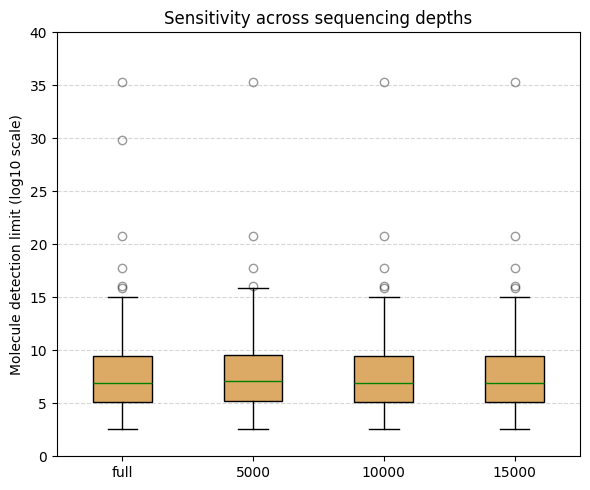

In [18]:
detection_limits_df_clean = detection_limits_df.dropna()

# Or drop per column if only some have NaNs
detection_limits_df_clean = detection_limits_df.dropna(how='any')


plt.figure(figsize=(6, 5))

plt.boxplot(
    [detection_limits_df_clean[col] for col in detection_limits_df_clean.columns],
    labels=detection_limits_df_clean.columns,
    patch_artist=True,
    boxprops=dict(facecolor="#DDAA66", edgecolor="black"),
    medianprops=dict(color="green"),
    flierprops=dict(marker='o', color='black', alpha=0.4)
)

plt.title("Sensitivity across sequencing depths")
plt.ylabel("Molecule detection limit (log10 scale)")
# plt.yscale("log")
plt.ylim(0, 40)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



/var/folders/8t/n_sl6bbd7qd5jmzh3f4wsvbr0000gn/T/ipykernel_98876/1763075569.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=limits_df, x='ReadDepth', y='DetectionLimit', inner='box', scale='width')


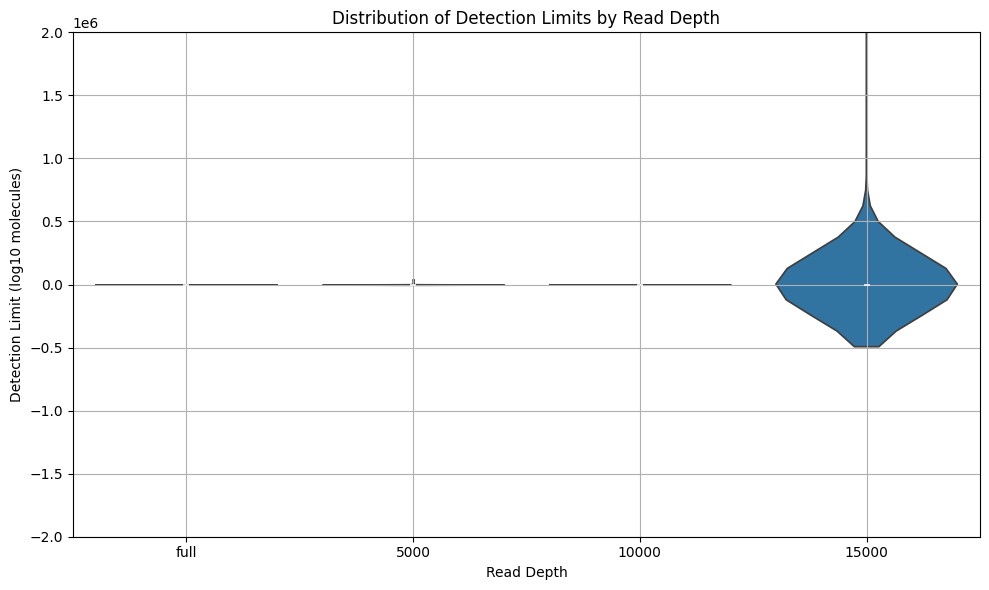

In [19]:
# Reset index to get 'Sample' as a column
limits_df = detection_limits_df.reset_index().melt(id_vars='Sample', var_name='ReadDepth', value_name='DetectionLimit')

# Drop NaNs or infs if any
limits_df = limits_df.replace([np.inf, -np.inf], np.nan).dropna()

# Plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=limits_df, x='ReadDepth', y='DetectionLimit', inner='box', scale='width')

plt.title("Distribution of Detection Limits by Read Depth")
plt.xlabel("Read Depth")
plt.ylabel("Detection Limit (log10 molecules)")
plt.ylim(-2000000, 2000000)
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/8t/n_sl6bbd7qd5jmzh3f4wsvbr0000gn/T/ipykernel_98876/982024046.py:7: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


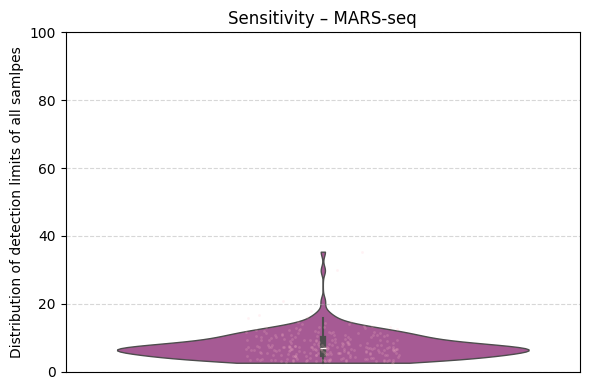

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))

# Violin plot (narrow, clipped)
sns.violinplot(
    y=detection_limits_df['full'],
    inner="box",
    scale="width",
    cut=0,
    linewidth=1,
    color="#B34D9B"  # choose a soft single color
)

# Overlaid points inside violin
sns.stripplot(
    y=detection_limits_df['full'],
    color="pink",
    alpha=0.2,
    jitter=0.15,
    size=2
)

# Tidy labels
plt.title("Sensitivity – MARS-seq")
plt.ylabel("Distribution of detection limits of all samlpes")
plt.ylim(0, 100)  # constrain y-axis like the paper
plt.xticks([])  # no x-tick label since one protocol
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Accuracy

In [21]:
def compute_all_accuracies(umitab_subsamples, ercc_concentration_df, common_erccs):
    """
    For each sequencing depth (including 'full'), compute per-sample Pearson R 
    between log10(ERCC concentration+1) and log10(ERCC count+1).
    Returns a DataFrame: rows = samples, columns = depths.
    """
    all_acc = {}

    for depth, df in umitab_subsamples.items():
        accs = {}
        for sample in df.columns:
            # 1) get counts & concentrations
            counts = df[sample].loc[common_erccs].astype(int)
            barcode = sample.split("_")[0]
            match = ercc_concentration_df[ercc_concentration_df.index.str.endswith(barcode)]
            if match.empty:
                continue
            concs = match.iloc[0][common_erccs].astype(float)

            # 2) only if at least 8 ERCCs detected
            if (counts > 0).sum() < 8:
                accs[sample] = np.nan
            else:
                x = np.log10(concs + 1)
                y = np.log10(counts + 1)
                r, _ = pearsonr(x, y)
                accs[sample] = r

        all_acc[depth] = accs

    # assemble into DataFrame
    accuracy_df = pd.DataFrame(all_acc)
    accuracy_df.index.name = "Sample"
    return accuracy_df


In [22]:
accuracy_df = compute_all_accuracies(
    umitab_subsamples_with_full,
    ercc_concentration_df,
    common_erccs
)
print(accuracy_df.head(-5))

                full      5000     10000     15000
Sample                                            
GCATTG_0    0.859273  0.821459  0.786928  0.772045
TTAATC_1    0.930995  0.859732  0.840456  0.833765
CTAACT_2    0.922667  0.905672  0.877652  0.876425
TTCGCT_3    0.914857  0.905436  0.881925  0.871539
GTCCAA_4    0.838448  0.785662  0.745825  0.732500
...              ...       ...       ...       ...
ATAGCG_230  0.922392  0.874820  0.837392  0.844924
ACTCTG_231  0.881099  0.849182  0.793513  0.774013
ATTATG_232  0.921456  0.887107  0.880345  0.873239
CAGTCA_233  0.851613  0.790015  0.753184  0.719769
TGTAAC_234  0.918448  0.875663  0.867728  0.861956

[235 rows x 4 columns]


In [28]:
# Median accuracy per depth
# don't take first row (full counts) and column
accuracy_df = accuracy_df.iloc[1:]  # skip the full counts row
median_accuracies = accuracy_df.median()
median_accuracies.name = "Median Accuracy"
median_accuracies.index.name = "Depth"
print(median_accuracies)

Depth
full     0.900928
5000     0.852185
10000    0.828868
15000    0.817633
Name: Median Accuracy, dtype: float64


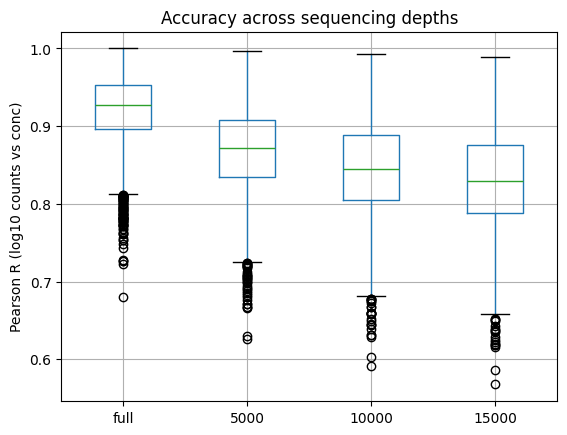

In [ ]:
accuracy_df.boxplot()
plt.ylabel("Pearson R (log10 counts vs conc)")
plt.title("Accuracy across sequencing depths")
plt.show()


/tmp/ipykernel_3054/1821743108.py:7: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


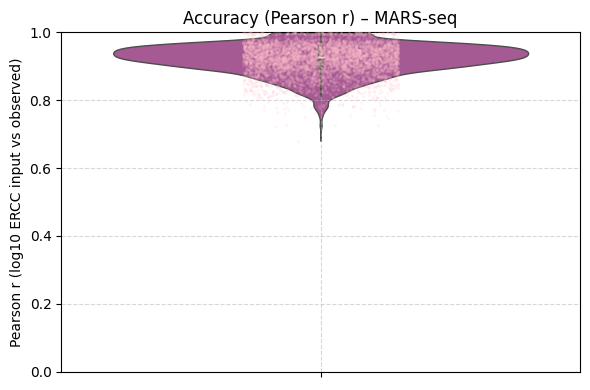

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))

# Violin plot (narrow, clipped)
sns.violinplot(
    y=accuracy_df['full'],
    inner="box",
    scale="width",
    cut=0,
    linewidth=1,
    color="#B34D9B"  # choose a soft single color
)

# Overlaid points inside violin
sns.stripplot(
    y=accuracy_df['full'],
    color="pink",
    alpha=0.2,
    jitter=0.15,
    size=2
)

plt.title("Accuracy (Pearson r) – MARS-seq")
plt.ylabel("Pearson r (log10 ERCC input vs observed)")
plt.xlabel("")
plt.ylim(0, 1)  # Pearson r range
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Unsupervised 

In [ ]:
from sklearn.preprocessing import StandardScaler

# (a) Log-transform counts
ercc_log = np.log10(ercc_concentration_df + 1)

# (b) Transpose for sample-wise analysis
X = ercc_log.T  # shape: samples × ERCCs

# (c) Standardize (optional but recommended)
X_scaled = StandardScaler().fit_transform(X)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_pca)

# Add cluster labels to a DataFrame for downstream analysis
cluster_labels = pd.Series(labels, index=ercc_concentration_df.columns, name="cluster")

# Join cluster labels with accuracy and detection limit
metrics_df = pd.DataFrame(index=ercc_concentration_df.columns)
metrics_df["cluster"] = cluster_labels
metrics_df["accuracy"] = accuracy_df["full"]
metrics_df["detection_limit"] = detection_limits_df["full"]
metrics_df["ercc_count"] = (ercc_concentration_df > 0).sum(axis=0)
metrics_df["total_counts"] = ercc_concentration_df.sum(axis=0)



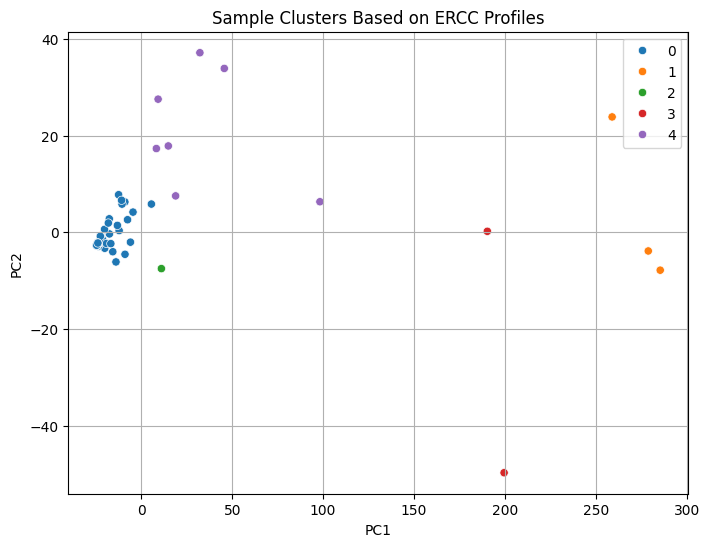

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='tab10')
plt.title("Sample Clusters Based on ERCC Profiles")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


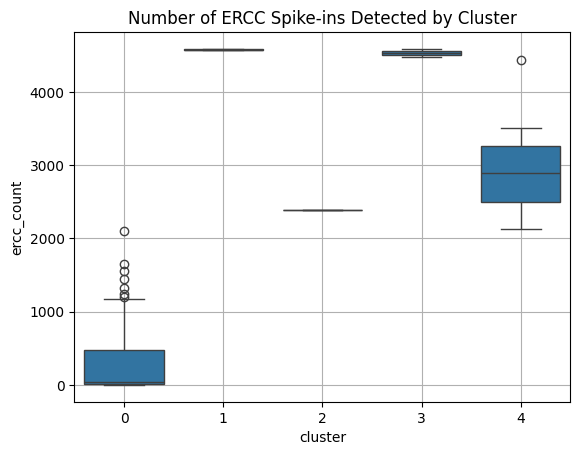

In [ ]:
sns.boxplot(data=metrics_df, x="cluster", y="ercc_count")
plt.title("Number of ERCC Spike-ins Detected by Cluster")
plt.grid(True)


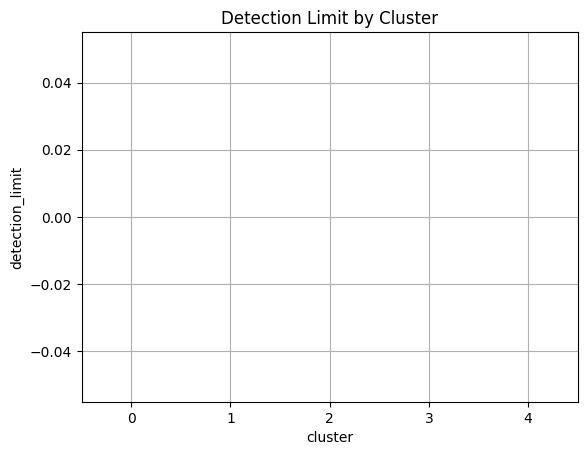

In [ ]:
sns.violinplot(data=metrics_df, x="cluster", y="detection_limit")
plt.title("Detection Limit by Cluster")
plt.grid(True)